# **LoRA-адаптер для стиля тату "одной линии"**
(сервис генерации уникальных эскизов тату TattiSketch)

# Инструкция для запуска ноутбука

Этот ноутбук выполняет:
- обучение LoRA-адаптера на датасете из 51-го эскиза тату (выполнены в стиле одной непрерывной линии) с использованием платформы Fal.ai;
- генерацию изображений на baseline-модели с использованием платформы Fal.ai;
- генерацию изображений на обученном LoRA-адаптере с использованием платформы Fal.ai;
- расчет, оценку и визуализацию метрик

**Для корректной работы требуется:**
- установить свой API-ключ Fal.ai через `userdata` или переменную `FAL_KEY`;
- загрузить архив `dataset.zip` с датасетом изображений в папку `/content/` для обучения LoRA-адаптера;
- загрузить референс `sample_line.png` в папку `/content/dataset/` для оценки метрик.

---


## 1. Установка зависимостей

In [1]:
!pip install fal-client requests Pillow opencv-python matplotlib scikit-image torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

## 2. Импорт библиотек и настройка API


In [4]:
import fal_client
import requests
import os
import re
import glob
import time
import math
import random
import cv2
import numpy as np
import itertools
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.measure import label
from scipy.spatial.distance import euclidean
import torch
from torchvision import models, transforms
from torchvision.models import VGG19_Weights
from google.colab import userdata
from fal_client import Queued, InProgress, Completed
from IPython.display import display


## Конфигурация


In [3]:
!mkdir -p dataset/refs generated/baseline generated/lora

In [5]:
FAL_KEY = userdata.get('FAL_API_KEY')
os.environ["FAL_KEY"] = FAL_KEY

# Референс
REF_IMAGE_PATH = "/content/dataset/sample_line.png"


## 3. Загрузка датасета на платформу Fal.ai

- загрузить `/content/dataset.zip` - для обучения в Fal.ai
- загрузить референс `/content/dataset/sample_line.png` для оценки метрик

In [ ]:
data_zip_url = fal_client.upload_file("dataset.zip")
print("ZIP загружен:", data_zip_url)

ZIP загружен: https://v3.fal.media/files/penguin/hcFwLHVT-yMDQo6nVq5nr_dataset.zip


## 4. Обучение LoRA-адаптера на платформе Fal.ai


In [ ]:
handler = fal_client.submit(
    "fal-ai/flux-lora-fast-training",
    arguments={
        "images_data_url": data_zip_url,
        "is_style": True,
        "steps": 3000,
        "trigger_word": "single continuous black line drawing, minimalism, no shading, no breaks",
        "create_masks": False
    }
)

while True:
    status = fal_client.status(
        "fal-ai/flux-lora-fast-training",
        handler.request_id,
        with_logs=True
    )

    if isinstance(status, Queued):
        print(f"В очереди (position={status.position})")

    elif isinstance(status, InProgress):
        for log in status.logs or []:
            print(log.get("message", "<no message>"))

    elif isinstance(status, Completed):
        print("Обучение завершено!")
        break

    else:
        raise RuntimeError(f"Unexpected status object: {status!r}")

    time.sleep(30)

result = fal_client.result("fal-ai/flux-lora-fast-training", handler.request_id)
lora_url = result["diffusers_lora_file"]["url"]
print("LoRA weights:", lora_url)

В очереди (position=0)
Archive files: 
[PosixPath('/tmp/tmpo2wx0qo9/47.png'), PosixPath('/tmp/tmpo2wx0qo9/24.png'), PosixPath('/tmp/tmpo2wx0qo9/39.png'), PosixPath('/tmp/tmpo2wx0qo9/12.png'), PosixPath('/tmp/tmpo2wx0qo9/16.png'), PosixPath('/tmp/tmpo2wx0qo9/7.png'), PosixPath('/tmp/tmpo2wx0qo9/40.png'), PosixPath('/tmp/tmpo2wx0qo9/19.png'), PosixPath('/tmp/tmpo2wx0qo9/27.png'), PosixPath('/tmp/tmpo2wx0qo9/1.png'), PosixPath('/tmp/tmpo2wx0qo9/4.png'), PosixPath('/tmp/tmpo2wx0qo9/46.png'), PosixPath('/tmp/tmpo2wx0qo9/13.png'), PosixPath('/tmp/tmpo2wx0qo9/15.png'), PosixPath('/tmp/tmpo2wx0qo9/32.png'), PosixPath('/tmp/tmpo2wx0qo9/42.png'), PosixPath('/tmp/tmpo2wx0qo9/31.png'), PosixPath('/tmp/tmpo2wx0qo9/25.png'), PosixPath('/tmp/tmpo2wx0qo9/48.png'), PosixPath('/tmp/tmpo2wx0qo9/44.png'), PosixPath('/tmp/tmpo2wx0qo9/23.png'), PosixPath('/tmp/tmpo2wx0qo9/30.png'), PosixPath('/tmp/tmpo2wx0qo9/22.png'), PosixPath('/tmp/tmpo2wx0qo9/18.png'), PosixPath('/tmp/tmpo2wx0qo9/3.png'), PosixPath('/tm

Файл весов обученного LoRA-адаптера ("steps": 1000):

In [ ]:
lora_url = "https://v3.fal.media/files/monkey/hL6DMp7b8D-7TET-o8Hk4_pytorch_lora_weights.safetensors"

Файл весов обученного LoRA-адаптера ("steps": 3000):

In [6]:
lora_url = "https://v3.fal.media/files/penguin/O1_RKyPsRx0phG9Dpy65P_pytorch_lora_weights.safetensors"

## 5. Генерация изображений:
- baseline - fal-ai/flux-lora;
- lora - fal-ai/flux-lora + обученный LoRA-адаптер (`lora_url`):
    - для активации весов LoRA-адаптера, обученного на 1000 шагах обновления весов модели, используется триггер: `<single_line_style>`;
    - для активации весов LoRA-адаптера, обученного на 3000 шагах обновления весов модели, используется триггер: `<single continuous black line drawing, minimalism, no shading, no breaks>`

In [12]:
MODEL = "fal-ai/flux-lora"
LORA  = lora_url

# Выбрать в зависимости от параметров обучения
TRIG  = "<single continuous black line drawing, minimalism, no shading, no breaks>"
# TRIG  = "<single_line_style>"

def generate(prompt, use_lora=False):
    seed = random.randint(1, 1_000_000_000)

    # Формируем основной текст промпта
    main_prompt = (
        f"{prompt}, "
        "clean, sharp, and bold outlines optimized for tattoo sketch, "
        "strong contrast and clear readability. "
    )

    args = {
        # Если включаем LoRA — добавляем в prompt триггер
        "prompt": f"{main_prompt} {TRIG}" if use_lora else main_prompt,
        "negative_prompt": (
            "filling, painting, pencil shading, grayscale shading, "
            "color gradients, blurred edges, sketchy lines, gray background, colour background"
        ),
        "image_size": { "width": 512, "height": 512 },
        "num_inference_steps": 44,
        "guidance_scale": 5.5,
        "seed": seed
    }

    if use_lora:
        args["loras"] = [{ "path": LORA, "scale": 0.9 }]

    result = fal_client.run(MODEL, arguments=args)
    url = result["images"][0]["url"]
    return Image.open(requests.get(url, stream=True).raw).convert("RGB")


# Директории для сохранения
os.makedirs("generated/baseline", exist_ok=True)
os.makedirs("generated/lora",     exist_ok=True)

# Список популярных тату
object_list = [
    "skull", "rose", "anchor", "rat", "cat", "wolf", "moon", "sun",
    "lion", "feather", "sun", "heart", "fish", "bird", "mountain", "tree",
    "diamond", "yoga", "clock", "flower", "dreamcatcher", "butterfly",
    "compass", "wave", "owl", "snake", "dragon", "crown", "arrow", "star"
]

prompts = random.sample(object_list, 15)

for i, p in enumerate(prompts):
    # Baseline (без LoRA)
    img_base = generate(p, use_lora=False)
    img_base.save(f"generated/baseline/baseline_{i}.png")

    # С LoRA-адаптером
    img_lora = generate(p, use_lora=True)
    img_lora.save(f"generated/lora/lora_{i}.png")


## 6. Визуализация сгенерированных результатов и референса:

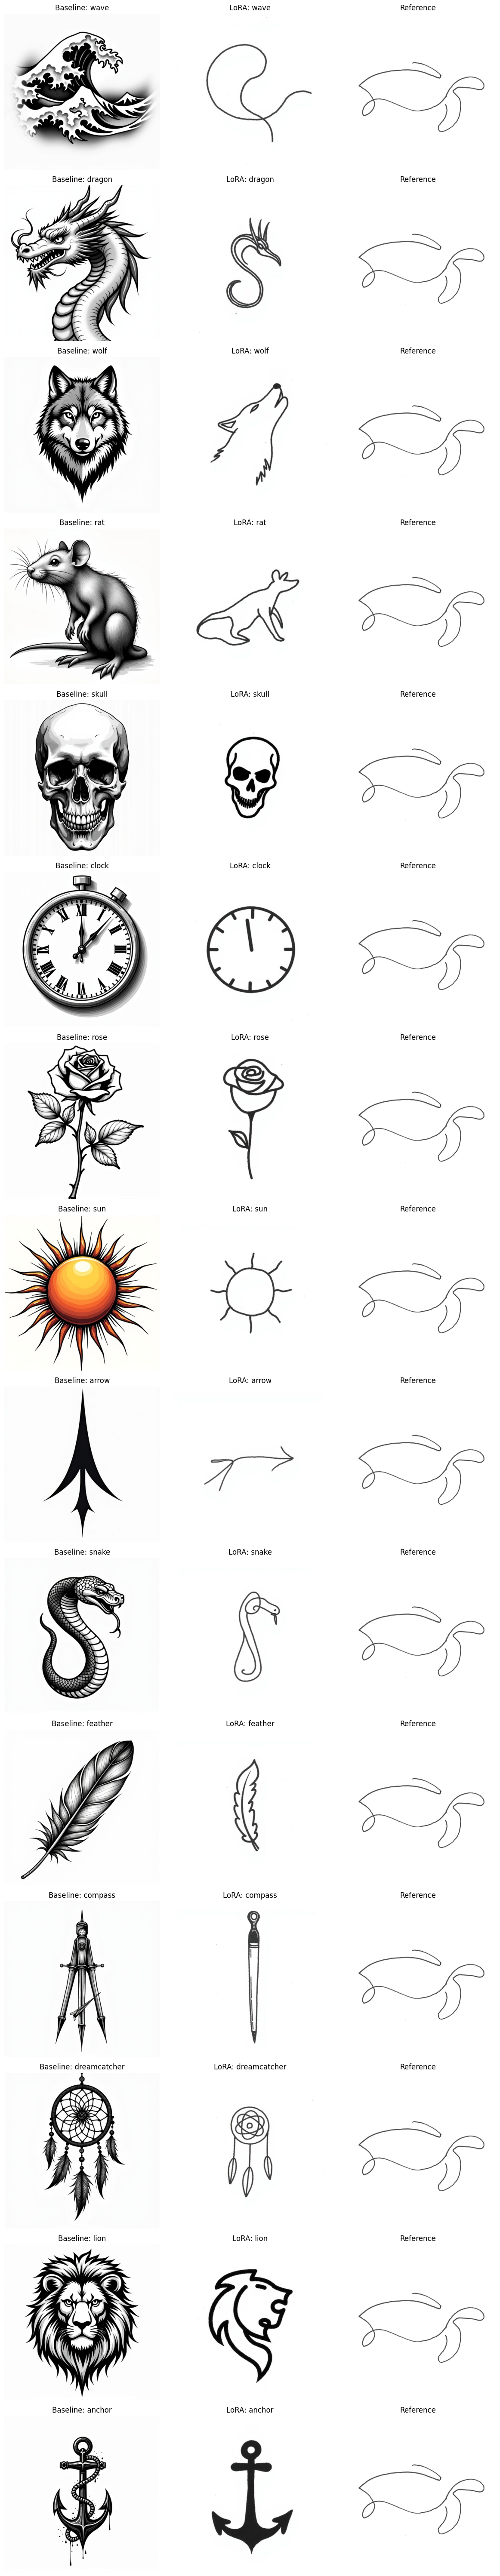

In [13]:
fig, ax_img = plt.subplots(len(prompts), 3, figsize=(12, 4 * len(prompts)))

for i, p in enumerate(prompts):
    img_b = Image.open(f"generated/baseline/baseline_{i}.png")
    img_l = Image.open(f"generated/lora/lora_{i}.png")
    img_r = Image.open(REF_IMAGE_PATH)

    ax_img[i, 0].imshow(img_b)
    ax_img[i, 0].set_title(f"Baseline: {p}")
    ax_img[i, 0].axis("off")

    ax_img[i, 1].imshow(img_l)
    ax_img[i, 1].set_title(f"LoRA: {p}")
    ax_img[i, 1].axis("off")

    ax_img[i, 2].imshow(img_r)
    ax_img[i, 2].set_title("Reference")
    ax_img[i, 2].axis("off")

plt.tight_layout()
plt.show()

## 7. Метрики качества:

Для количественной оценки ключевых особенностей стиля выполнения эскиза тату "одной линии" выбраны следующие метрики:


1. **Skeleton‑based** метрики:

   – components: число непрерывных частей линии - отдельных "кусочков" скелета изображения, не связанных между собой (components=1 означает, что весь скелет представляет собой единую связную структуру без разрывов). Для стиля "одной линии" должно быть components==1;

   – endpoints: количество концевых точек - пиксели с ровно 1 соседом (конец линии). Для стиля "одной линии" должно быть endpoints==2 (начало и конец);

   – branches: точки ветвления - пиксели с >=3 соседями (места, где линии раздваиваются). Для стиля "одной линии" заначение зависит от количества пересечений линии, но как правило не превышать 10;

   – length: общая длина скелета (в пикселях);

   – tortuosity: отношение длины к прямому расстоянию между концами (если endpoints==2).

2. **Style Loss**:

   – инициализирует VGG-19 с предобученными весами и берёт только сверточные фичи;
   
   – преобразует изображение и эталон в формат, ожидаемый моделью (Resize, ToTensor, Normalize);
   
   – считает Gram-матрицы признаков VGG и возвращает среднеквадратичную разницу между ними, показывая, насколько глубинные паттерны линий сгенерированного изображения отличаются от эталона.

3. **Human Style Score (HSS)**:

   – запрашивает у пользователя субъективную оценку (1–5) для каждого изображения, чтобы учесть человеческое восприятие «правильности» стиля "одной линии".


### 7.1. Оценка Skeleton‑based метрик

#### 7.1.1. Расчет Skeleton‑based метрик для выбранного из датасета референса - получение таким образом «нормы» стиля выполнения тату "одной линии":

In [14]:
def preprocess(img, thr=200):
    """
    1. Конвертирует RGB в BGR, если нужно (для PIL Images)
    2. Конвертирует BGR-изображение в серое.
    3. Бинаризует (линия → белый фон → чёрное).
    4. Выполняет морфологическое closing, чтобы убрать мелкие разрывы.
    5. Возвращает двоичную маску (0/1) для последующего скелетирования.
    """

    if isinstance(img, np.ndarray) and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, bw = cv2.threshold(g, thr, 255, cv2.THRESH_BINARY_INV)
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=2)

    return (bw > 0).astype(np.uint8)

def largest_skeleton(mask, min_size=50):
    """
    1. Строит скелет (однопиксельную «ось») из двоичной маски.
    2. Помечает связанные компоненты на скелете.
    3. Оставляет только те компоненты, чьи размеры ≥ min_size (фильтрация артефактов).
    """

    skel = skeletonize(mask.astype(bool))
    lbl = label(skel, connectivity=2)

    # Фильтрация компонентов
    component_sizes = np.bincount(lbl.ravel())
    small_components = np.where(component_sizes < min_size)[0]
    mask = np.isin(lbl, small_components, invert=True)

    return (skel * mask).astype(np.uint8)

def neighbours(skel):
    """
    Считает для каждого пикселя скелета число соседей в 8-окрестности.
    Это нужно для детекции концов (1 сосед) и развилок (≥3 соседей).
    """

    return cv2.filter2D(skel, -1, np.array([[1,1,1],[1,0,1],[1,1,1]], np.uint8))

def sk_metrics(img):
    """
    1. Препроцессинг и постобработка скелета (largest_skeleton).
    2. Определяет:
       - components  (число связанных компонент)
       - endpoints   (пиксели с 1 соседом)
       - branches    (пиксели с ≥3 соседями)
       - length      (общая длина скелета, в пикселях)
       - tortuosity  (отношение длины скелета к прямому расстоянию между концами, если концов ровно 2)
    3. Возвращает все метрики в виде словаря.
    """

    skel = largest_skeleton(preprocess(img))
    if skel.sum() == 0:
        return dict(components=0, endpoints=0, branches=0, length=0, tortuosity=math.nan)
    neigh = neighbours(skel)
    comps = label(skel, connectivity=2).max()
    ep    = int(np.logical_and(skel==1, neigh==1).sum())
    bp    = int(np.logical_and(skel==1, neigh>=3).sum())
    lng   = int(skel.sum())
    tort  = math.nan
    if ep == 2:
        pts = np.column_stack(np.where(np.logical_and(skel==1, neigh==1)))
        if euclidean(pts[0], pts[1]) > 1e-6:  # Защита от деления на ноль
            tort = lng / euclidean(pts[0], pts[1])
    return dict(components=comps,endpoints=ep,branches=bp,length=lng,tortuosity=tort)

imgs_ref = {"Reference": REF_IMAGE_PATH}

# Расчет нормы метрик и вывод результатов в таблицу
data = {name: sk_metrics(cv2.imread(path)) for name, path in imgs_ref.items()}
ref_df   = pd.DataFrame(data).T
display(ref_df)


components  endpoints  branches  length  tortuosity
Reference         1.0        2.0       4.0  1283.0    7.334902

#### 7.1.2. Визуализация скелетов по каждому промпту:

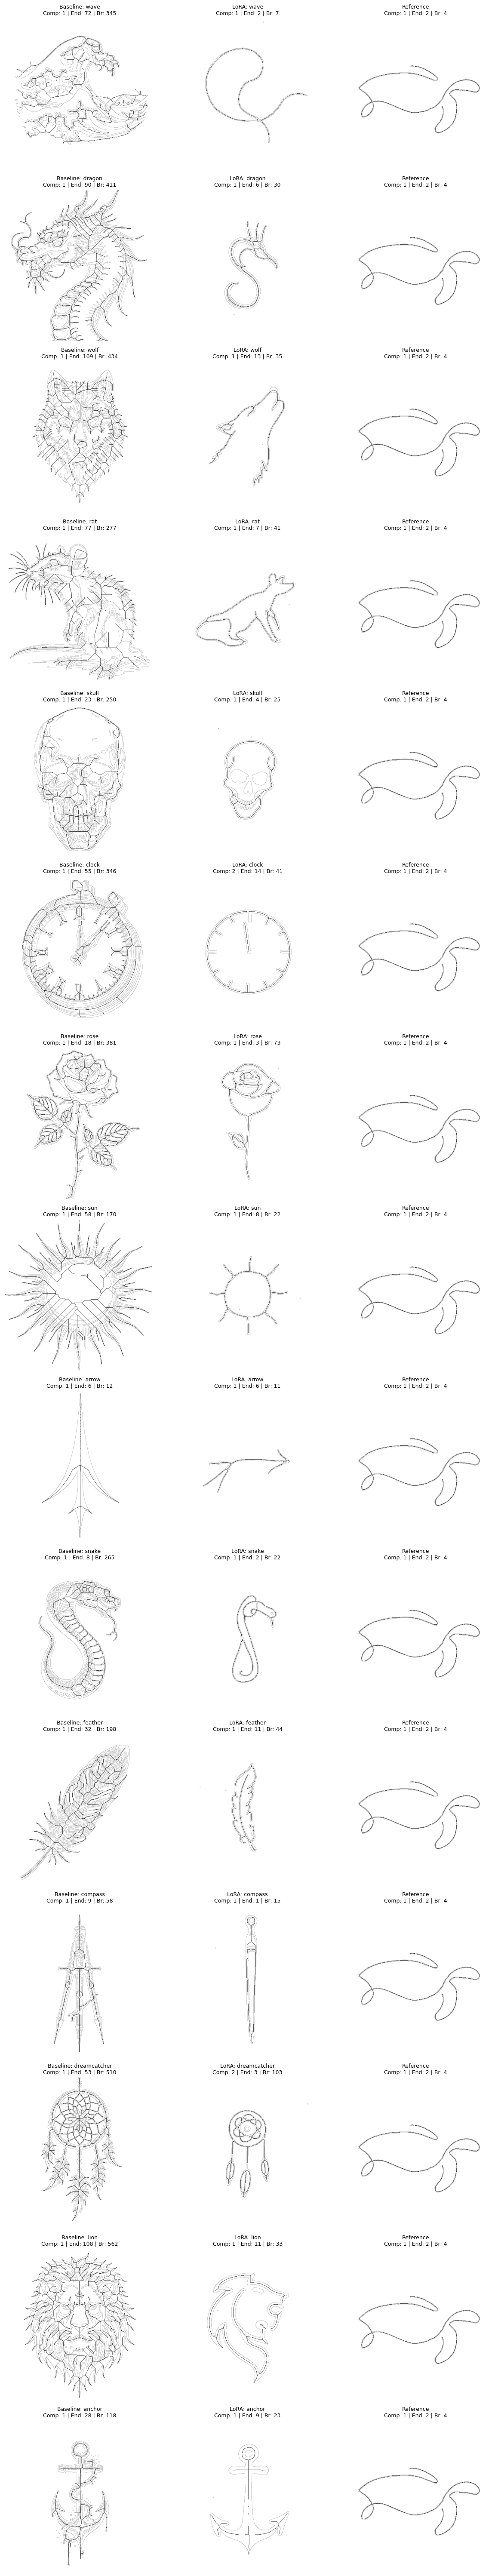

In [15]:
def get_skeleton_for_visualization(pil_img):
    """Отдельная функция для визуализации, идентичная расчету метрик"""
    img_np = np.array(pil_img.convert('RGB'))[:, :, ::-1]  # RGB->BGR
    mask = preprocess(img_np)
    skel = largest_skeleton(mask)

    # Для визуализации добавляем контуры оригинального изображения
    contours = cv2.Canny(cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY), 100, 200)
    return (skel * 255 + contours * 0.3).clip(0, 255).astype(np.uint8)

fig, axs = plt.subplots(len(prompts), 3, figsize=(12, 4 * len(prompts)))

for i, p in enumerate(prompts):
    # Загрузка и обработка
    img_b = Image.open(f"generated/baseline/baseline_{i}.png")
    img_l = Image.open(f"generated/lora/lora_{i}.png")
    img_r = Image.open(REF_IMAGE_PATH)

    # Получаем скелеты и метрики
    skel_b = get_skeleton_for_visualization(img_b)
    skel_l = get_skeleton_for_visualization(img_l)
    skel_r = get_skeleton_for_visualization(img_r)

    metrics_b = sk_metrics(np.array(img_b)[:, :, ::-1])
    metrics_l = sk_metrics(np.array(img_l)[:, :, ::-1])

    # Визуализация с аннотациями метрик
    def plot_skel(ax, skel, title, metrics):
        ax.imshow(skel, cmap='gray_r', vmin=0, vmax=255)
        ax.set_title(f"{title}\n"
                    f"Comp: {metrics['components']} | "
                    f"End: {metrics['endpoints']} | "
                    f"Br: {metrics['branches']}", fontsize=9)
        ax.axis("off")

    plot_skel(axs[i, 0], skel_b, f"Baseline: {p}", metrics_b)
    plot_skel(axs[i, 1], skel_l, f"LoRA: {p}", metrics_l)
    plot_skel(axs[i, 2], skel_r, "Reference", sk_metrics(np.array(img_r)[:, :, ::-1]))

plt.tight_layout()
plt.show()


#### 7.1.3. Расчет Skeleton‑based метрик для baseline-решения по каждому промпту:

In [16]:
# Получаем пути и сортируем ЧИСЛА в названиях файлов (не лексикографически)
baseline_paths = sorted(
    glob.glob("generated/baseline/baseline_*.png"),
    key=lambda x: int(re.search(r'baseline_(\d+)\.png', x).group(1))
)

# Создаем словарь {номер: prompt} для гарантированного соответствия
prompt_dict = {i: prompt for i, prompt in enumerate(prompts)}

records = []
for path in baseline_paths:
    # Извлекаем номер из имени файла
    file_num = int(re.search(r'baseline_(\d+)\.png', path).group(1))

    # Берем соответствующий промпт
    if file_num in prompt_dict:
        img = cv2.imread(path)
        if img is not None:
            metrics = sk_metrics(img)
            metrics["prompt"] = prompt_dict[file_num]
            records.append(metrics)
        else:
            print(f"Ошибка загрузки: {path}")
    else:
        print(f"Нет промпта для файла {path}")

# Создаем DataFrame
baseline_df = pd.DataFrame(records).set_index("prompt")
baseline_df.index.name = None

# Стилизация
styled = (
    baseline_df.style
    .set_properties(**{'text-align': 'left'})
    .set_table_styles([
        {'selector': 'th.col_heading', 'props': [('text-align', 'left')]},
        {'selector': 'th.row_heading', 'props': [('text-align', 'left')]},
    ])
)

display(styled)


#### 7.1.4. Расчет Skeleton‑based метрик для LoRA по каждому промпту:

In [17]:
import re

# Получаем пути и сортируем ЧИСЛА в названиях файлов (не лексикографически)
baseline_paths = sorted(
    glob.glob("generated/lora/lora_*.png"),
    key=lambda x: int(re.search(r'lora_(\d+)\.png', x).group(1))
)

# Создаем словарь {номер: prompt} для гарантированного соответствия
prompt_dict = {i: prompt for i, prompt in enumerate(prompts)}

records = []
for path in baseline_paths:
    # Извлекаем номер из имени файла
    file_num = int(re.search(r'lora_(\d+)\.png', path).group(1))

    # Берем соответствующий промпт
    if file_num in prompt_dict:
        img = cv2.imread(path)
        if img is not None:
            metrics = sk_metrics(img)
            metrics["prompt"] = prompt_dict[file_num]
            records.append(metrics)
        else:
            print(f"Ошибка загрузки: {path}")
    else:
        print(f"Нет промпта для файла {path}")

# Создаем DataFrame
lora_df = pd.DataFrame(records).set_index("prompt")
lora_df.index.name = None

# Стилизация
styled = (
    lora_df.style
    .set_properties(**{'text-align': 'left'})
    .set_table_styles([
        {'selector': 'th.col_heading', 'props': [('text-align', 'left')]},
        {'selector': 'th.row_heading', 'props': [('text-align', 'left')]},
    ])
)

display(styled)


#### 7.1.5. Сравнение средних значений Skeleton‑based метрик baseline и LoRA с референсным значением:

Сравнение средних значений skeleton-based метрик и референса:


components  endpoints    branches       length  tortuosity
Baseline     1.000000  49.733333  289.133333  3948.533333         NaN
LoRA         1.133333   6.666667   35.000000  1070.400000    5.314680
Reference    1.000000   2.000000    4.000000  1283.000000    7.334902

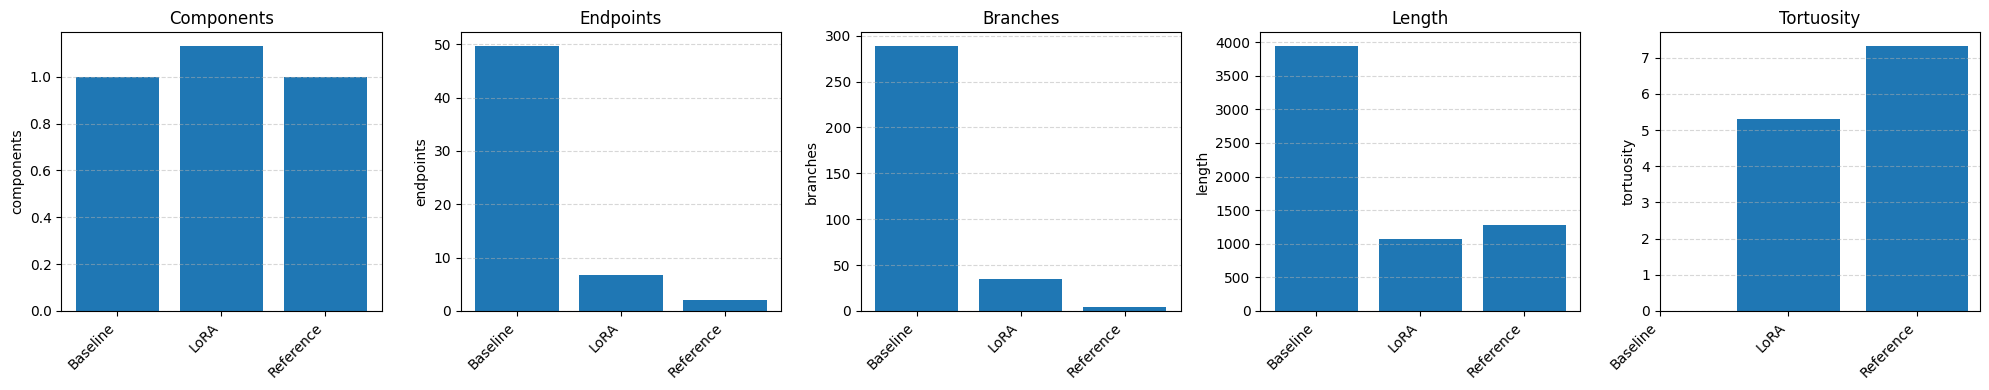

In [18]:
ref_mean = ref_df.mean(numeric_only=True) if len(ref_df)>1 else ref_df.iloc[0]

# Расчет средних значений
baseline_mean = baseline_df.mean(numeric_only=True)
lora_mean     = lora_df.mean(numeric_only=True)

# Формирование итоговой таблицы
summary_skeleton = pd.DataFrame({
    "Baseline":  baseline_mean,
    "LoRA":      lora_mean,
    "Reference": ref_mean
}).T

# Вывод таблицы
print("Сравнение средних значений skeleton-based метрик и референса:")
display(summary_skeleton)

# Визуализация сравнения средних метрик
metrics = summary_skeleton.columns.tolist()
fig, axes = plt.subplots(1, len(metrics), figsize=(4 * len(metrics), 4), sharey=False)

for ax, m in zip(axes, metrics):
    ax.bar(summary_skeleton.index, summary_skeleton[m])
    ax.set_title(m.capitalize())
    ax.set_ylabel(m)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_xticks(range(len(summary_skeleton.index)))
    ax.set_xticklabels(summary_skeleton.index, rotation=45, ha="right")

plt.tight_layout()
plt.show()


#### 7.1.6. Оценка результатов:

- **components**:

  Baseline сохраняет цельную линию (components == 1), но «перерисовывает поверх» — отсюда **большое количество endpoints/branches/length**.

  LoRA иногда «раскалывает» рисунок на 2 сегмента (разрывы ≤ 1 px). Возможная причина - микропросветы 1 – 2 px или случайные «вторые штрихи». В обучающем наборе скорее всего встречались крошечные разрывы, скан-шум, «двойной» штрих, соответственно, модель решила, что лёгкий разрыв — допустим.

- **endpoints**:

  LoRA сократила количество «обрывов» в ~7 раз, однако ещё в 3 раза выше эталона.

- **branches**:

  LoRA снизила ветвистость в ~8 раз — наглядный прогресс к минимализму.

- **length**:

  Baseline «наматывал» лишние петли.

  У LoRA длина линии почти совпала с эталоном.

- **tortuosity**:

  Эталонные рисунки имеют запутанную траекторию. LoRA пока «чересчур прямолинейна» — визуально выглядит минималистичней, но ей недостает характерных плавных завитков. Датасет содержит мало примеров с изящными петлями. LoRA тренировалась «быстро» (3 000 step), возможно, что не успела уловить тонкие изгибы.


### 7.2. Оценка метрик Style Loss и HSS + визуализация

#### 7.2.1. Расчет Style Loss и Human Style Score (HSS) метрик по каждому промпту:

In [23]:
# Инициализируем VGG-19 с актуальными весами и берем только фичи
weights = VGG19_Weights.IMAGENET1K_V1  # или VGG19_Weights.DEFAULT
vgg = models.vgg19(weights=weights).features.eval()
REF_IMAGE = Image.open(REF_IMAGE_PATH).convert("RGB")

# Штатная предобработка для этих весов
preproc = weights.transforms()

def gram_matrix(x: torch.Tensor) -> torch.Tensor:
    b, d, h, w = x.size()
    f = x.view(b * d, h * w)
    return torch.mm(f, f.t()) / (b * d * h * w)

def style_loss(generated: Image.Image, reference: Image.Image) -> float:

    target_size = (512, 512)  # Фиксированный размер для стабильности

    gen = preproc(generated).unsqueeze(0)  # [1, 3, H, W]
    ref = preproc(reference).unsqueeze(0)
    with torch.no_grad():
        f_gen = vgg(gen)
        f_ref = vgg(ref)
        return torch.mean((gram_matrix(f_gen) - gram_matrix(f_ref)) ** 2).item()

# Счетчики
metrics = {"Baseline": {"StyleLoss": [], "HSS": []},
           "LoRA":     {"StyleLoss": [], "HSS": []}}

# Собираем StyleLoss
for i, prompt in enumerate(prompts):
    img_b = Image.open(f"generated/baseline/baseline_{i}.png").convert("RGB")
    img_l = Image.open(f"generated/lora/lora_{i}.png").convert("RGB")
    metrics["Baseline"]["StyleLoss"].append(style_loss(img_b, REF_IMAGE))
    metrics["LoRA"]["StyleLoss"].append(style_loss(img_l, REF_IMAGE))

# Запрашиваем HSS у пользователя
print("Введите HSS (1–5) для каждого изображения:")
for model in ["Baseline","LoRA"]:
    for i, p in enumerate(prompts):
        val = float(input(f"{model} — {p}: "))
        metrics[model]["HSS"].append(val)

# Формируем DataFrame с индексом — промпты, и столбцами для каждой метрики и модели
df_metrics = pd.DataFrame({
    "Baseline StyleLoss": metrics["Baseline"]["StyleLoss"],
    "LoRA StyleLoss":     metrics["LoRA"]["StyleLoss"],
    "Baseline HSS":       metrics["Baseline"]["HSS"],
    "LoRA HSS":           metrics["LoRA"]["HSS"],
}, index=prompts)

df_metrics.index.name = None

# Стилизация
df_metrics["Baseline StyleLoss"] = df_metrics["Baseline StyleLoss"] / 1e-6
df_metrics["LoRA StyleLoss"]     = df_metrics["LoRA StyleLoss"]     / 1e-6

styled = (
    df_metrics.style
        .format({
            "Baseline StyleLoss": "{:.2f}",
            "LoRA StyleLoss":     "{:.2f}",
            "Baseline HSS":       "{:.1f}",
            "LoRA HSS":           "{:.1f}"
        })
        .set_properties(**{'text-align': 'left'})
        .set_table_styles([
            {'selector': 'th.col_heading', 'props': [('text-align', 'left')]},
            {'selector': 'th.row_heading', 'props': [('text-align', 'left')]},
        ])
)
print("Style Loss (1e-6) и Human Style Score (HSS) метрики по каждому промпту:")
display(styled)


Введите HSS (1–5) для каждого изображения:
Baseline — wave: 1
Baseline — dragon: 1
Baseline — wolf: 1
Baseline — rat: 1
Baseline — skull: 1
Baseline — clock: 1
Baseline — rose: 1
Baseline — sun: 1
Baseline — arrow: 1
Baseline — snake: 1
Baseline — feather: 1
Baseline — compass: 1
Baseline — dreamcatcher: 1
Baseline — lion: 1
Baseline — anchor: 1
LoRA — wave: 4
LoRA — dragon: 3
LoRA — wolf: 3
LoRA — rat: 3
LoRA — skull: 3
LoRA — clock: 2
LoRA — rose: 3
LoRA — sun: 2
LoRA — arrow: 3
LoRA — snake: 3
LoRA — feather: 3
LoRA — compass: 3
LoRA — dreamcatcher: 3
LoRA — lion: 2
LoRA — anchor: 3
Style Loss (1e-6) и Human Style Score (HSS) метрики по каждому промпту:


#### 7.2.2. Визуализация Style Loss и Human Style Score (HSS) метрик по каждому промпту:

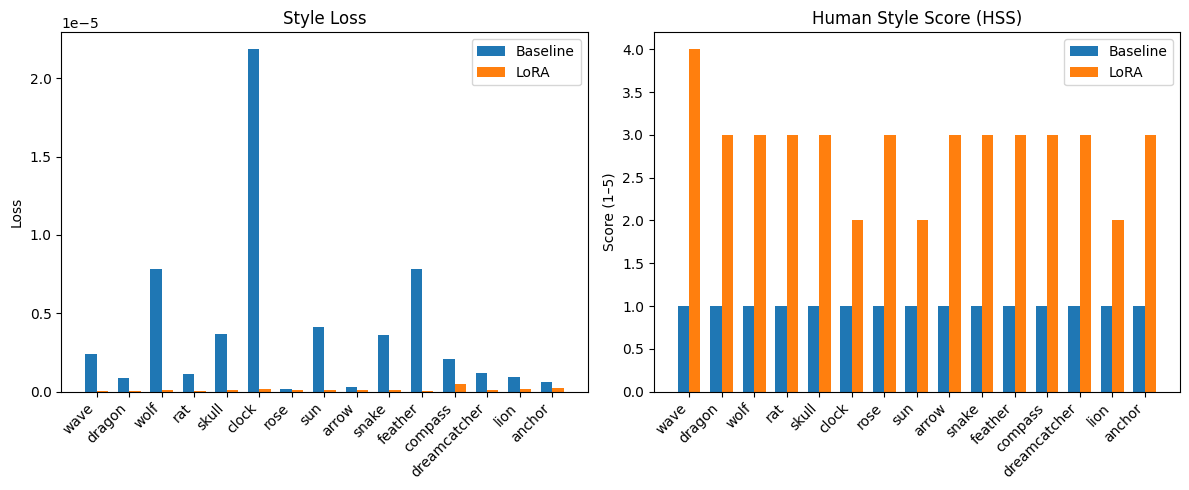

In [24]:
# Визуализация: два bar-чарта в ряд
x    = np.arange(len(prompts))
w    = 0.35
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Style Loss
axes[0].bar(x - w/2, metrics["Baseline"]["StyleLoss"], w, label="Baseline")
axes[0].bar(x + w/2, metrics["LoRA"]["StyleLoss"],     w, label="LoRA")
axes[0].set_xticks(x)
axes[0].set_xticklabels(prompts, rotation=45, ha="right")
axes[0].set_title("Style Loss")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Human Style Score
axes[1].bar(x - w/2, metrics["Baseline"]["HSS"], w, label="Baseline")
axes[1].bar(x + w/2, metrics["LoRA"]["HSS"],     w, label="LoRA")
axes[1].set_xticks(x)
axes[1].set_xticklabels(prompts, rotation=45, ha="right")
axes[1].set_title("Human Style Score (HSS)")
axes[1].set_ylabel("Score (1–5)")
axes[1].legend()

plt.tight_layout()
plt.show()


#### 7.2.3. Сравнение средних значений Style Loss и Human Style Score (HSS) метрик baseline и LoRA:

Средние значения Style Loss (1e-6) и HSS метрик:


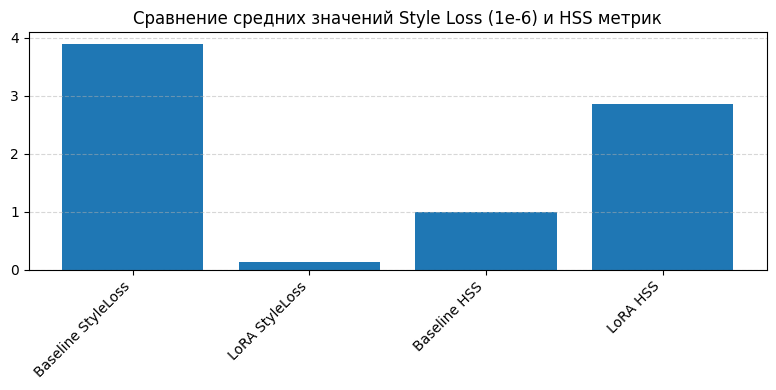

In [25]:
# Расчет средних значений по каждому столбцу
mean_vals = df_metrics.mean(numeric_only=True)
# Формирование строки–DataFrame для наглядного отображения
mean_df = mean_vals.to_frame(name="Mean").T
mean_df.index.name = None

# Стилизация и вывод таблицы
styled_mean = (
    mean_df.style
        .format({
            "Baseline StyleLoss": "{:.2f}",
            "LoRA StyleLoss":     "{:.2f}",
            "Baseline HSS":       "{:.1f}",
            "LoRA HSS":           "{:.1f}"
        })
        .set_properties(**{'text-align': 'left'})
        .set_table_styles([
            {'selector': 'th', 'props': [('text-align', 'left')]},
        ])
)
print("Средние значения Style Loss (1e-6) и HSS метрик:")
display(styled_mean)

# Визуализация средних значений — горизонтальный ряд из 4 баров
metrics_order = [
    "Baseline StyleLoss", "LoRA StyleLoss",
    "Baseline HSS",       "LoRA HSS"
]
values = mean_df.iloc[0][metrics_order].values

fig, ax = plt.subplots(figsize=(8,4))
x = range(len(metrics_order))
ax.bar(x, values)
ax.set_title("Сравнение средних значений Style Loss (1e-6) и HSS метрик")
ax.set_ylabel("")
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Сначала задаём позиции для тиков...
ax.set_xticks(x)
# ... а затем подписываем их
ax.set_xticklabels(metrics_order, rotation=45, ha="right")

plt.tight_layout()
plt.show()


#### 7.2.4. Оценка результатов:

- **Style Loss:**

  LoRA-адаптер уменьшил стилевое расхождение почти в 30 раз.

  Baseline имеет большие Gram-расхождения.

  Во всех 15 промптах Style Loss для LoRA ≤ 0.51 × 10⁻⁶ (большинство ≈ 0.05) - стиль **почти** идентичен эталону.

  Самые «трудные» baseline-слова — clock (21.8 × 10⁻⁶), wolf, feather (≈ 8 × 10⁻⁶). LoRA на тех же промптах падает до десятых-сотых долей.

- **HSS:**
  
  Субъективно LoRA воспринимается как «узнаваемый стиль», до идеала (4-5) не дотягивает из-за редких разрывов и иногда недостаточной изящности линии.

  Субъективно Baseline - это вообще не стиль тату "одной линии".

## 8. Выводы:

### При использовании LoRA-адаптера результаты стали значительно ближе к стилистике техники "одной линии", но пока не стабильны.

**Причина:**
- fal-ai/flux — это базовый text-to-image движок - он не был специально натренирован на следование правилам "одной линии", и полученные веса LoRA-адаптера не позволяют стабильно достигать требуемого результата.

**Предложения по улучшению результата:**
- Увеличить датасет: взять не 51, а, например, 100 референсов, выполненных в стиле тату "одной линии" (без разрывов, шумов, фона, теней, все изображения - одинакового размера черно-белые). Дополнительные референсы должны быть с хорошо замкнутой петлёй и выразительными изгибами (модель будет видеть, что разрыв — ошибка, а плавные петли — норма).

- Добавить в датасет копии с лёгким расширением/сужением линии, но без разрывов (OpenCV `cv2.dilate / erode`). Это покажет модели, что толщина может плавать, а целостность — не должна.

- Тренировать больше шагов: 5000 шагов дадут лучшее закрепление.

- При инференсе немного повысить пораметр LoRA-scale - это усилит влияние адаптера, поможет «заклеить» микропрорывы.

- Попробовать реализовать тонкую post-обработка сгенерированных изображений.